<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 2

</h4>

# Personal Data

In [1]:
# Set your student number
student_number = 400101272
Name = 'Mohammad Mahdi'
Last_Name = 'Razmjoo'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**.
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [2]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

100%|██████████| 26421880/26421880 [00:04<00:00, 6577809.60it/s] 


Extracting MNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268864.47it/s]


Extracting MNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4501819.43it/s]


Extracting MNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4551491.78it/s]

Extracting MNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_data/FashionMNIST/raw



### Data Exploration
Let's take a look at the classes in our dataset.

In [4]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

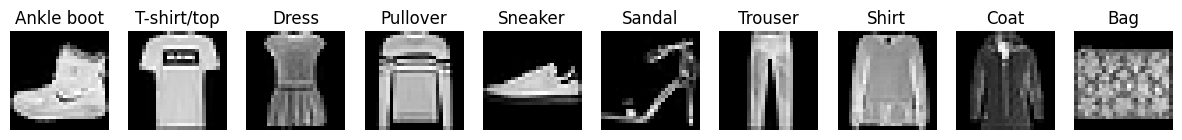

In [5]:
class_samples = {}

for i in range(len(dataset)):
    img, label = dataset[i]
    class_name = dataset.classes[label]
    if class_name not in class_samples:
        class_samples[class_name] = img
        if len(class_samples) == len(dataset.classes):
            break

fig, axs = plt.subplots(1, len(dataset.classes), figsize=(15, 3))
for i, (class_name, sample) in enumerate(class_samples.items()):
    axs[i].imshow(sample.squeeze().numpy(), cmap='gray')
    axs[i].set_title(class_name)
    axs[i].axis('off')

plt.show()

### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset.

In [6]:
def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]

In [7]:
val_frac = 0.2 ## Set the fraction for the validation set
rand_seed = 42 ## Set the random seed

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("number of samples in training set: {}".format(len(train_indices)))
print("number of samples in validation set: {}".format(len(val_indices)))

number of samples in training set: 48000
number of samples in validation set: 12000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide.

In [8]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [9]:
batch_size = 64 ## Set the batch size
# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset,
                     batch_size,
                     sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset,
                   batch_size,
                   sampler=val_sampler)

Plot images in a sample batch of data.

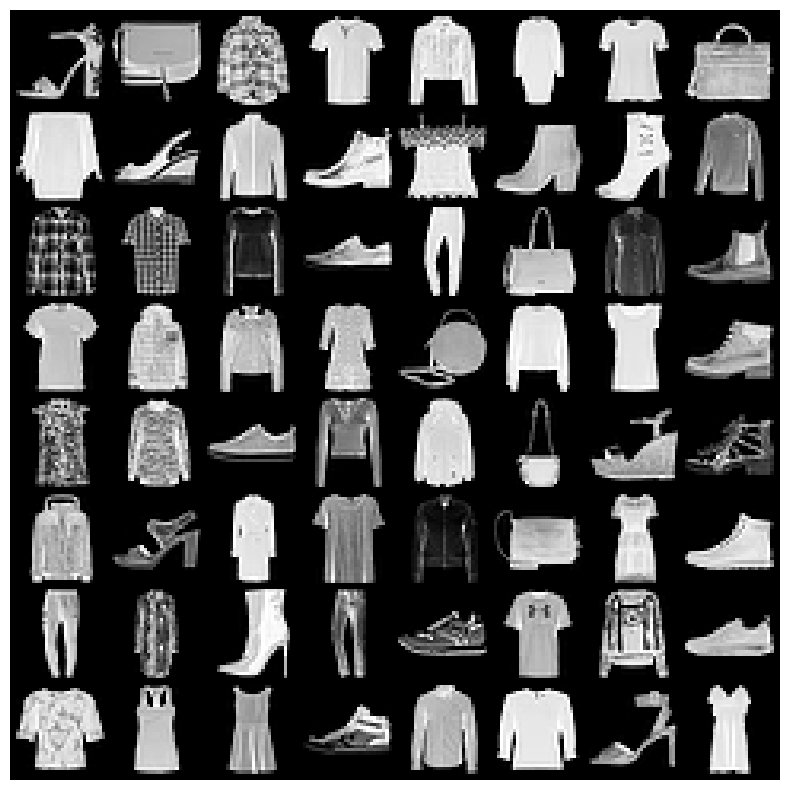

In [10]:
import torchvision.utils as vutils

sample_batch = next(iter(train_dl))

plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(sample_batch[0][:64], padding=2, normalize=True),
        (1, 2, 0)
    )
)
plt.show()

In [11]:
!pip install torchinfo
!pip install ipywidgets==7.7.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.6 MB/s eta 0:00:00


### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [12]:
# Import required packages
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

In [13]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=1):
        super(ImageClassifierNet, self).__init__()
        self.conv1 = nn.Conv2d(n_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, X):
        X = self.pool(nn.functional.relu(self.conv1(X)))
        X = self.pool(nn.functional.relu(self.conv2(X)))
        X = X.view(-1, 32 * 7 * 7)
        X = nn.functional.relu(self.fc1(X))
        X = self.fc2(X)
        return X

In [14]:
model = ImageClassifierNet()

The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [15]:
summary(model, input_size=(batch_size, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Linear: 1-5                            [64, 128]                 200,832
├─Linear: 1-6                            [64, 10]                  1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (M): 79.17
Input size (MB): 0.20
Forward/backward pass size (MB): 9.70
Params size (MB): 0.83
Estimated Total Size (MB): 10.73

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [16]:
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm

class CustomConv2d:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 0.01
        self.bias = torch.zeros(out_channels)
        self.weight.requires_grad = True
        self.bias.requires_grad = True

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = F.pad(x, (self.padding, self.padding, self.padding, self.padding))
        out_dim = (x.shape[-1] - self.kernel_size) // self.stride + 1
        out = torch.zeros((x.shape[0], self.out_channels, out_dim, out_dim))
        for i in range(out_dim):
            for j in range(out_dim):
                x_slice = x[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                out[:, :, i, j] = (x_slice.unsqueeze(1) * self.weight).sum(dim=(2, 3, 4)) + self.bias
        return out

class CustomMaxPool2d:
    def __init__(self, kernel_size, stride):
        self.kernel_size = kernel_size
        self.stride = stride

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        out_dim = (x.shape[-1] - self.kernel_size) // self.stride + 1
        out = torch.zeros((x.shape[0], x.shape[1], out_dim, out_dim))

        for i in range(out_dim):
            for j in range(out_dim):
                x_slice = x[:, :, i*self.stride:i*self.stride+self.kernel_size, j*self.stride:j*self.stride+self.kernel_size]
                out[:, :, i, j] = x_slice.max(dim=-1)[0].max(dim=-1)[0]
        return out

class CustomReLU:
    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        return torch.max(x, torch.tensor(0.0))

class CustomLinear:
    def __init__(self, in_features, out_features):
        self.weight = torch.randn(out_features, in_features) * 0.01
        self.bias = torch.zeros(out_features)
        self.weight.requires_grad = True
        self.bias.requires_grad = True

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        return x @ self.weight.T + self.bias

class CustomCrossEntropyLoss:
    def __call__(self, outputs, targets):
        return self.forward(outputs, targets)

    def forward(self, outputs, targets):
        log_probs = F.log_softmax(outputs, dim=1)
        return -log_probs[range(len(targets)), targets].mean()

class CustomSGD:
    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

    def step(self):
        for param in self.params:
            if param.grad is not None:
                param.data -= self.lr * param.grad

class ImageClassifierNet:
    def __init__(self):
        self.conv1 = CustomConv2d(1, 16, 3, stride=1, padding=1)
        self.conv2 = CustomConv2d(16, 32, 3, stride=1, padding=1)
        self.pool = CustomMaxPool2d(2, 2)
        self.relu = CustomReLU()
        self.fc1 = CustomLinear(32 * 7 * 7, 128)
        self.fc2 = CustomLinear(128, 10)

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def parameters(self):
        return [self.conv1.weight, self.conv1.bias,
                self.conv2.weight, self.conv2.bias,
                self.fc1.weight, self.fc1.bias,
                self.fc2.weight, self.fc2.bias]


def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.

    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate

    Returns:
        The trained model.
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    optimizer = opt_fn(model.parameters(), lr=lr)
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_dl.sampler)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        if val_dl:
            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for inputs, labels in val_dl:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_loss /= len(val_dl.dataset) if val_dl else 1
            val_accuracy = correct / total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
            print(f"Epoch {epoch+1}/{n_epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train accuracy: {train_accuracy:.3f}.. "
                  f"Val loss: {val_loss:.3f}.. "
                  f"Val accuracy: {val_accuracy:.3f}")
        else:
            print(f"Epoch {epoch+1}/{n_epochs}.. "
                  f"Train loss: {train_loss:.3f}.. "
                  f"Train accuracy: {train_accuracy:.3f}")

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [17]:
num_epochs = 10
loss_fn = CustomCrossEntropyLoss()
opt_fn = CustomSGD
lr = 0.001

In [18]:
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)

Epoch 1/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 1/10.. Train loss: 2.230.. Train accuracy: 0.279.. Val loss: 0.425.. Val accuracy: 0.367


Epoch 2/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 2/10.. Train loss: 1.879.. Train accuracy: 0.477.. Val loss: 0.311.. Val accuracy: 0.601


Epoch 3/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 3/10.. Train loss: 1.256.. Train accuracy: 0.639.. Val loss: 0.209.. Val accuracy: 0.672


Epoch 4/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 4/10.. Train loss: 0.934.. Train accuracy: 0.686.. Val loss: 0.173.. Val accuracy: 0.701


Epoch 5/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 5/10.. Train loss: 0.814.. Train accuracy: 0.712.. Val loss: 0.157.. Val accuracy: 0.720


Epoch 6/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 6/10.. Train loss: 0.752.. Train accuracy: 0.731.. Val loss: 0.147.. Val accuracy: 0.740


Epoch 7/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 7/10.. Train loss: 0.711.. Train accuracy: 0.745.. Val loss: 0.140.. Val accuracy: 0.750


Epoch 8/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 8/10.. Train loss: 0.679.. Train accuracy: 0.757.. Val loss: 0.134.. Val accuracy: 0.762


Epoch 9/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 9/10.. Train loss: 0.652.. Train accuracy: 0.766.. Val loss: 0.129.. Val accuracy: 0.767


Epoch 10/10:   0%|          | 0/750 [00:00<?, ?it/s]

Epoch 10/10.. Train loss: 0.629.. Train accuracy: 0.774.. Val loss: 0.125.. Val accuracy: 0.778


### Plot loss and accuracy

In [19]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

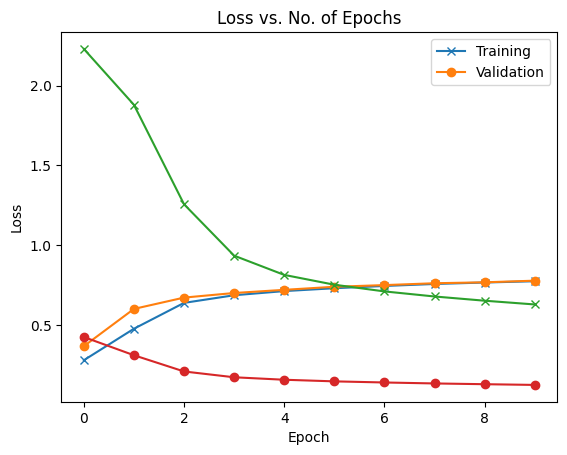

In [20]:
plot_accuracy(train_accuracies, val_accuracies)
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [21]:
indices, _ = split_indices(len(dataset), 0, rand_seed)

sampler = SubsetRandomSampler(indices)
dl = DataLoader(dataset, batch_size, sampler=sampler)

In [22]:
num_epochs = 15
lr = 0.001

In [23]:
model, _, _, _, _ = train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)

Epoch 1/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/15.. Train loss: 0.608.. Train accuracy: 0.783


Epoch 2/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/15.. Train loss: 0.585.. Train accuracy: 0.791


Epoch 3/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/15.. Train loss: 0.564.. Train accuracy: 0.799


Epoch 4/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/15.. Train loss: 0.546.. Train accuracy: 0.807


Epoch 5/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/15.. Train loss: 0.529.. Train accuracy: 0.812


Epoch 6/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/15.. Train loss: 0.513.. Train accuracy: 0.819


Epoch 7/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/15.. Train loss: 0.500.. Train accuracy: 0.823


Epoch 8/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/15.. Train loss: 0.486.. Train accuracy: 0.829


Epoch 9/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/15.. Train loss: 0.475.. Train accuracy: 0.834


Epoch 10/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/15.. Train loss: 0.465.. Train accuracy: 0.836


Epoch 11/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 11/15.. Train loss: 0.455.. Train accuracy: 0.840


Epoch 12/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 12/15.. Train loss: 0.446.. Train accuracy: 0.842


Epoch 13/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 13/15.. Train loss: 0.438.. Train accuracy: 0.847


Epoch 14/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 14/15.. Train loss: 0.431.. Train accuracy: 0.850


Epoch 15/15:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 15/15.. Train loss: 0.425.. Train accuracy: 0.850


### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

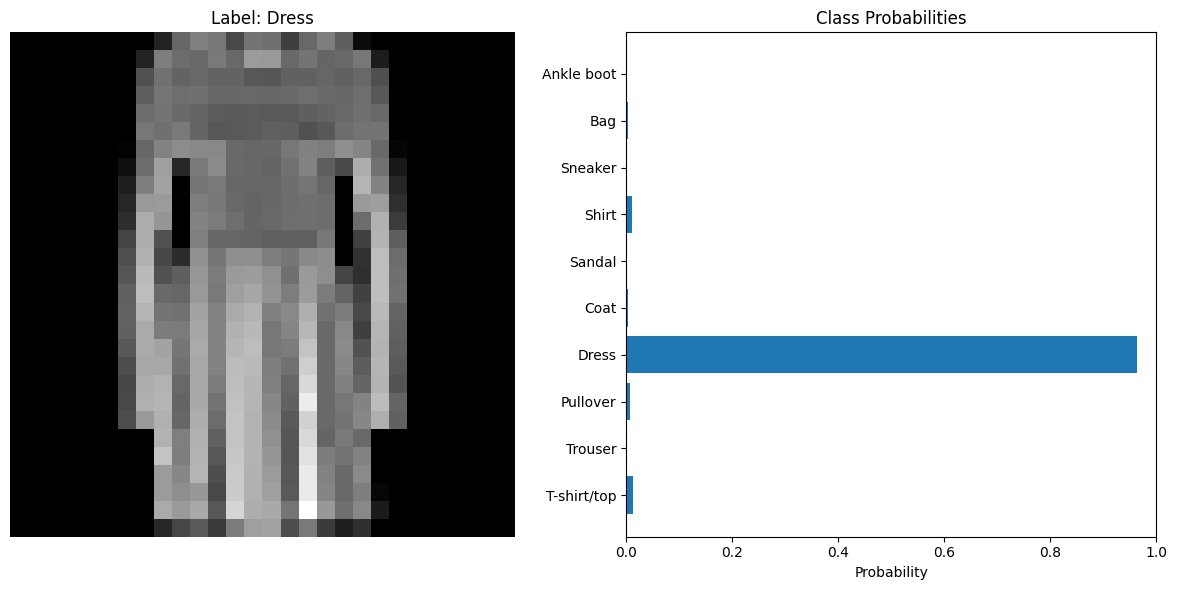

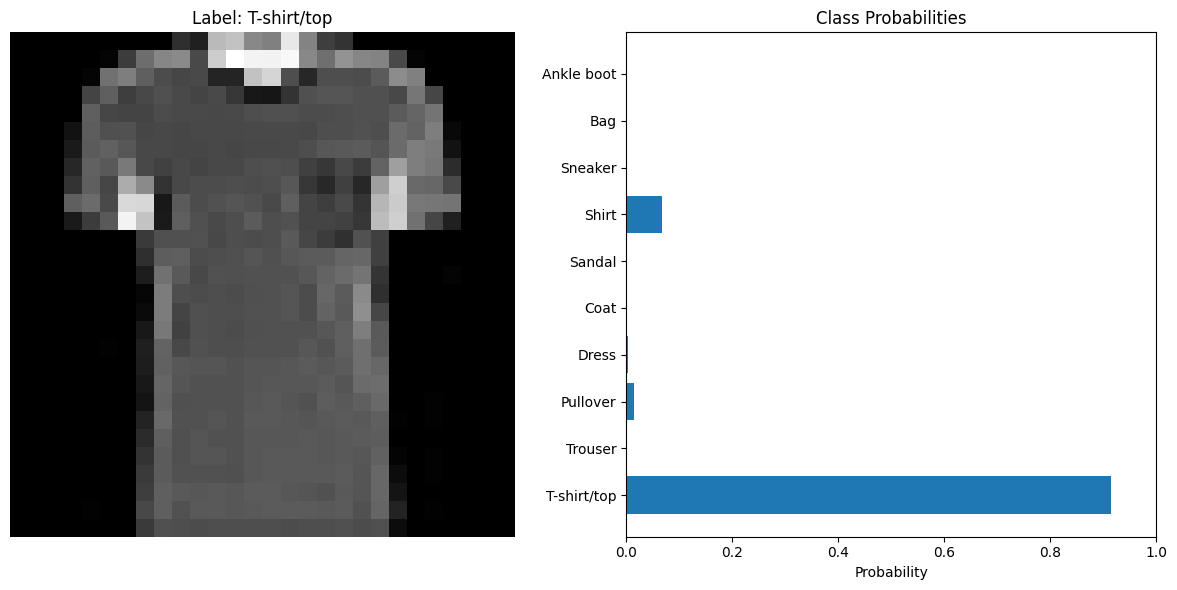

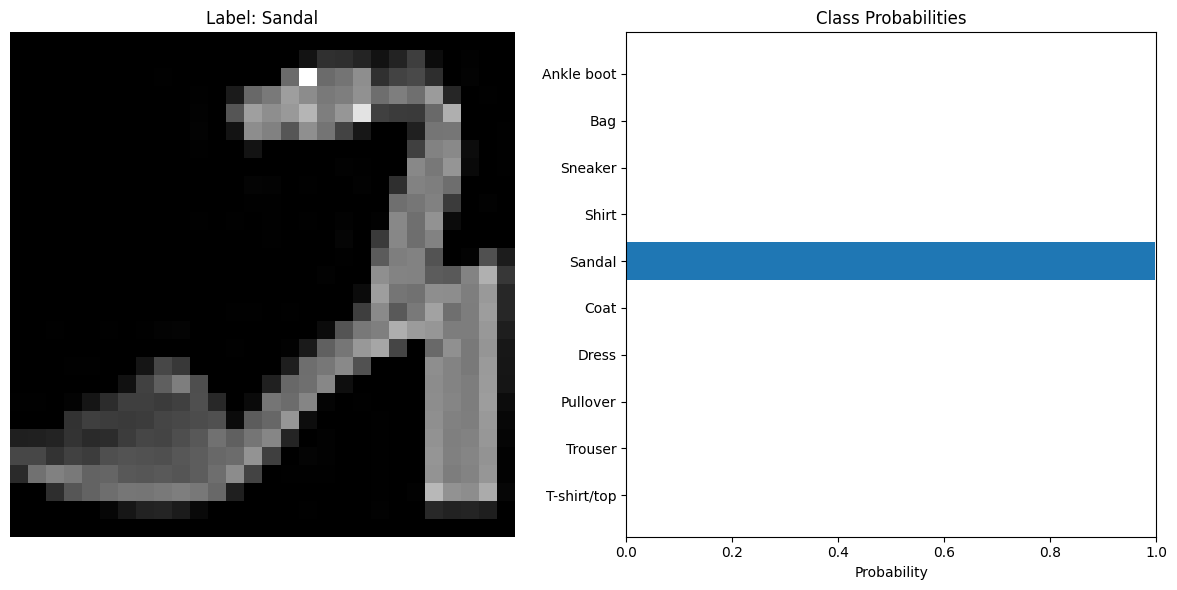

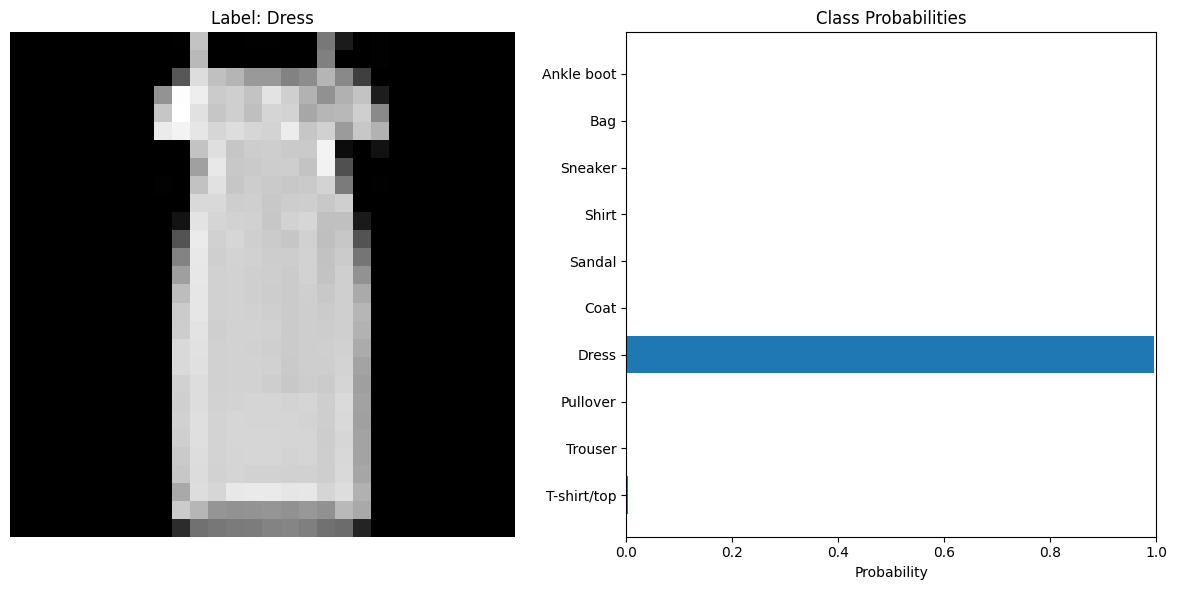

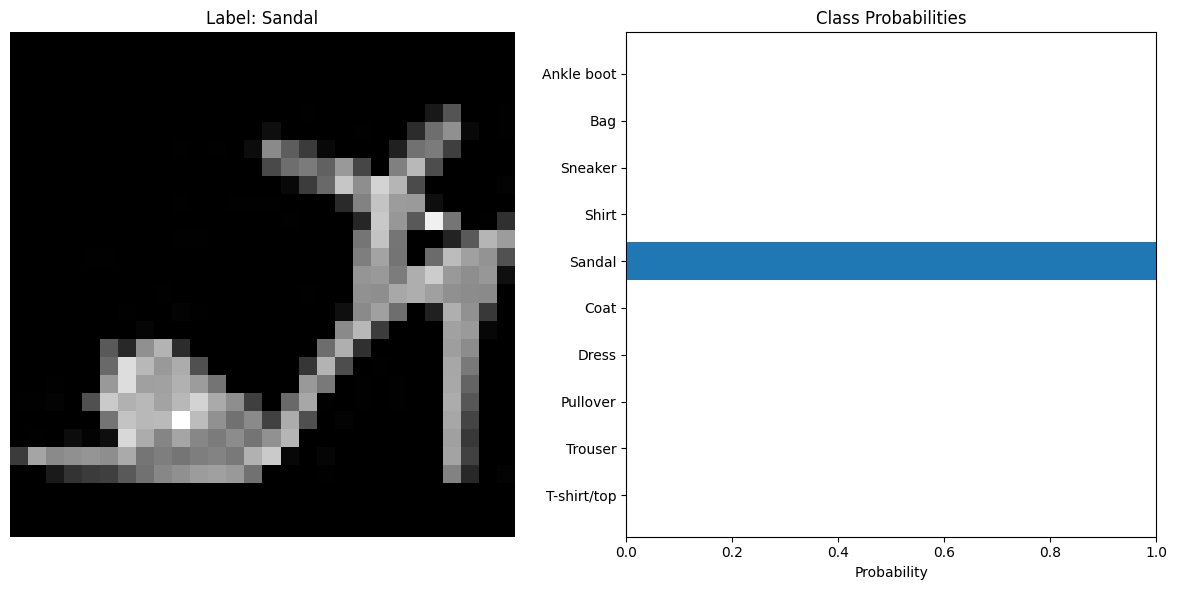

In [24]:
def view_prediction(image, label, probabilities, class_names):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title(f"Label: {class_names[label]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.barh(class_names, probabilities)
    plt.xlabel('Probability')
    plt.title('Class Probabilities')
    plt.xlim(0, 1)

    plt.tight_layout()
    plt.show()

model.eval()
sample_indices = np.random.choice(indices, size=5, replace=False)

for idx in sample_indices:
    image, label = dataset[idx]
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        probabilities = torch.nn.functional.softmax(output, dim=1).squeeze().numpy()

    view_prediction(image.squeeze().numpy(), label, probabilities, dataset.classes)

### Save the model

In [25]:
torch.save(model, 'model')

PicklingError: Can't pickle <class '__main__.ImageClassifierNet'>: it's not the same object as __main__.ImageClassifierNet

### Calculate accuracy on the test set

In [26]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

In [27]:
def evaluate(model, test_dl):
    """
    Evaluates your model on the test data.

    Args:
        model: ImageClassifierNet object
        test_dl: test dataloader

    Returns:
        Test accuracy.
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dl:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_accuracy = correct / total if total > 0 else 0
    return test_accuracy

In [28]:
print("Test Accuracy = {:.4f}".format(evaluate(model, test_dl)))

Test Accuracy = 0.8421
